# Pixel-based Classification Workflow with `arcgis.learn`

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li><li><span><a href="#Export-training-data-for-deep-learning" data-toc-modified-id="Export-training-data-for-deep-learning-2">Export training data for deep learning</a></span><ul class="toc-item"><li><span><a href="#Import-ArcGIS-API-for-Python-and-get-connected-to-your-GIS" data-toc-modified-id="Import-ArcGIS-API-for-Python-and-get-connected-to-your-GIS-2.1">Import ArcGIS API for Python and get connected to your GIS</a></span></li><li><span><a href="#Prepare-data-that-will-be-used-for-training-data-export" data-toc-modified-id="Prepare-data-that-will-be-used-for-training-data-export-2.2">Prepare data that will be used for training data export</a></span></li><li><span><a href="#Specify-a-folder-name-in-raster-store-that-will-be-used-to-store-our-training-data" data-toc-modified-id="Specify-a-folder-name-in-raster-store-that-will-be-used-to-store-our-training-data-2.3">Specify a folder name in raster store that will be used to store our training data</a></span></li><li><span><a href="#Export-training-data-using-arcgis.learn" data-toc-modified-id="Export-training-data-using-arcgis.learn-2.4">Export training data using <code>arcgis.learn</code></a></span></li></ul></li><li><span><a href="#Model-training" data-toc-modified-id="Model-training-3">Model training</a></span><ul class="toc-item"><li><span><a href="#Visualize-training-data" data-toc-modified-id="Visualize-training-data-3.1">Visualize training data</a></span></li><li><span><a href="#Load-model-architecture" data-toc-modified-id="Load-model-architecture-3.2">Load model architecture</a></span></li><li><span><a href="#Train-a-model-through-learning-rate-tuning-and-transfer-learning" data-toc-modified-id="Train-a-model-through-learning-rate-tuning-and-transfer-learning-3.3">Train a model through learning rate tuning and transfer learning</a></span></li><li><span><a href="#Visualize-classification-results-in-validation-set" data-toc-modified-id="Visualize-classification-results-in-validation-set-3.4">Visualize classification results in validation set</a></span></li></ul></li><li><span><a href="#Deployment-and-inference" data-toc-modified-id="Deployment-and-inference-4">Deployment and inference</a></span><ul class="toc-item"><li><span><a href="#Locate-model-package" data-toc-modified-id="Locate-model-package-4.1">Locate model package</a></span></li><li><span><a href="#Model-inference" data-toc-modified-id="Model-inference-4.2">Model inference</a></span></li></ul></li><li><span><a href="#Visualize-land-cover-classification-on-map" data-toc-modified-id="Visualize-land-cover-classification-on-map-5">Visualize land cover classification on map</a></span></li></ul></div>

## Introduction

As an example, we use land cover classification to demonstrate of workflow of pixel-based image classification using `arcgis.learn`. To begin with, we need input imagery as well as labels for each pixel. With the ArcGIS platform, these datasets are represented as layers, and are available in our GIS. This guide notebook showcases an end-to-end to land cover classification workflow using ArcGIS API for Python. The workflow consists of three major steps: (1) extract training data, (2) train a deep learning **image segmentation** model, (3) deploy the model for inference and create maps. To better illustrate this process, we will use NAIP imagery and high-resolution labeled data provided by the [Chesapeake Conservancy land cover project](https://chesapeakeconservancy.org/conservation-innovation-center/high-resolution-data/land-cover-data-project/).
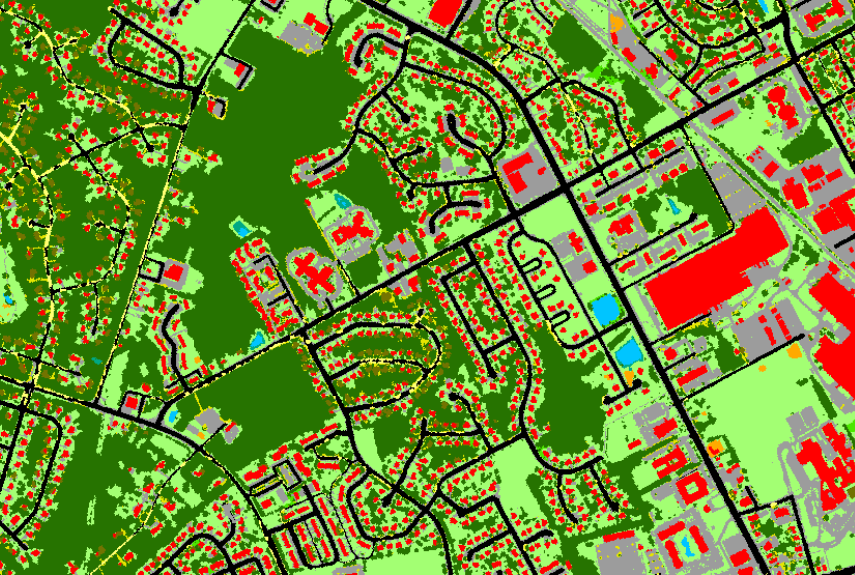
<center> Figure 1. A subset of of the labeled data for Kent county, Delaware

## Export training data for deep learning

### Import ArcGIS API for Python and get connected to your GIS

In [1]:
from arcgis import GIS

In [4]:
gis = GIS("home")

### Prepare data that will be used for training data export

To export training data, we need a _labeled imagery layer_ that contains the class label for each location, and a _raster input_ that contains all the original pixels and band information. In this land cover classification case, we will be using a subset of the one-meter resolution Kent county, Delaware, dataset as the labeled imagery layer and USA NAIP Imagery: Color Infrared as the raster input.

In [63]:
label_layer = gis.content.search("Kent_county_full_label_land_cover")[1] # the index might change
label_layer

<Item title:"Kent_county_full_label_land_cover" type:Imagery Layer owner:portaladmin>


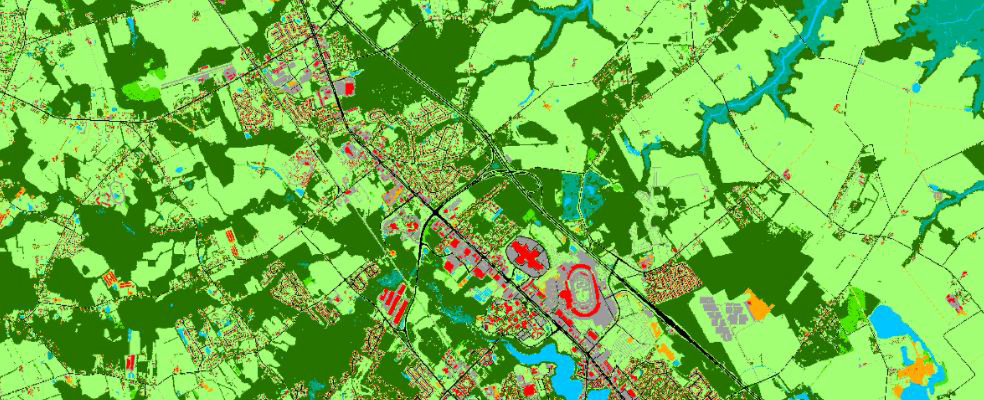

In [91]:
m = gis.map("Kent county, Delaware")
m

Now let's retrieve the NAIP image layer.

<Item title:"USA NAIP Imagery: Color Infrared" type:Imagery Layer owner:esri_livingatlas>
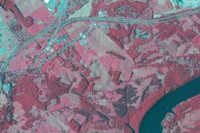

In [65]:
naip_item = gis.content.get('e4da3b6720f545aeaaf3fe8141da1e21')
naip_item

In [ ]:
from arcgis.raster.functions import extract_band

naiplayer = naip_item.layers[0]
naip_input_layer = extract_band(naiplayer, [5,3,2])

In [67]:
m.add_layer(naip_input_layer)

In [68]:
m.add_layer(label_layer)

###  Specify a folder name in raster store that will be used to store our training data

Make sure a raster store is ready on your raster analytics image server. This is where where the output subimages, also called chips, labels and metadata files are going to be stored.

In [32]:
from arcgis.raster import analytics

In [14]:
ds = analytics.get_datastores(gis=gis)
ds

<DatastoreManager for https://datascienceadv.esri.com/server/admin>

In [15]:
ds.search()

[<Datastore title:"/nosqlDatabases/AGSDataStore_bigdata_bds_4c9tuc3o" type:"nosql">,
 <Datastore title:"/nosqlDatabases/AGSDataStore_nosqldb_tcs_l6mh5mhm" type:"nosql">,
 <Datastore title:"/enterpriseDatabases/AGSDataStore_ds_b6108wk9" type:"egdb">,
 <Datastore title:"/rasterStores/LocalRasterStore" type:"rasterStore">]

In [16]:
rasterstore = ds.get("/rasterStores/LocalRasterStore")
rasterstore

<Datastore title:"/rasterStores/LocalRasterStore" type:"rasterStore">

In [17]:
samplefolder = "landcover_sample"
samplefolder

'landcover_sample'

### Export training data using `arcgis.learn`

With the feature class and raster layer, we are now ready to export training data using the export_training_data() method in arcgis.learn module. In addtion to feature class, raster layer, and output folder, we also need to speficy a few other parameters such as tile_size (size of the image chips), strid_size (distance to move each time when creating the next image chip), chip_format (TIFF, PNG, or JPEG), metadata format (how we are going to store those training labels). More detail can be found [here](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm). 

Depending on the size of your data, tile and stride size, and computing resources, this opertation can take 15mins~2hrs in our experiment. Also, do not re-run it if you already run it once unless you would like to update the setting.

In [18]:
import arcgis
from arcgis import learn
arcgis.env.verbose = True

In [17]:
export = learn.export_training_data(input_raster=naip_input_layer,
                                    output_location=samplefolder,
                                    input_class_data=label_layer.url, 
                                    chip_format="PNG", 
                                    tile_size={"x":400,"y":400}, 
                                    stride_size={"x":0,"y":0}, 
                                    metadata_format="Classified_Tiles",                                        
                                    context={"startIndex": 0, "exportAllTiles": False, "cellSize": 2},
                                    context = context,
                                    gis = gis)

Submitted.
Executing...
Start Time: Wednesday, May 22, 2019 9:34:15 AM
Running script ExportTrainingDataforDeepLearning...
No cloud raster store.
Exporting...
Succeeded at Wednesday, May 22, 2019 9:56:49 AM (Elapsed Time: 22 minutes 33 seconds)


Now let's get into the raster store and look at what has been generated and exported.

In [18]:
from arcgis.raster.analytics import list_datastore_content

samples = list_datastore_content(rasterstore.datapath + '/' + samplefolder + "/images", filter = "*png")
# print out the first five chips/subimages
samples[0:5]

Submitted.
Executing...
Start Time: Wednesday, May 22, 2019 1:04:14 PM
Running script ListDatastoreContent...


['/rasterStores/LocalRS/landcover_sample/images/000000000.png',
 '/rasterStores/LocalRS/landcover_sample/images/000000001.png',
 '/rasterStores/LocalRS/landcover_sample/images/000000002.png',
 '/rasterStores/LocalRS/landcover_sample/images/000000003.png',
 '/rasterStores/LocalRS/landcover_sample/images/000000004.png']

In [19]:
labels = list_datastore_content(rasterstore.datapath + '/' + samplefolder + "/labels", filter = "*png")
# print out the labels images for the first five chips
labels[0:5]

Start Time: Wednesday, May 22, 2019 1:04:19 PM
Running script ListDatastoreContent...
Completed script ListDatastoreContent...
Succeeded at Wednesday, May 22, 2019 1:04:19 PM (Elapsed Time: 0.05 seconds)


['/rasterStores/LocalRS/landcover_sample/labels/000000000.png',
 '/rasterStores/LocalRS/landcover_sample/labels/000000001.png',
 '/rasterStores/LocalRS/landcover_sample/labels/000000002.png',
 '/rasterStores/LocalRS/landcover_sample/labels/000000003.png',
 '/rasterStores/LocalRS/landcover_sample/labels/000000004.png']

## Model training

If you've already done part 1, you should already have the training chips. Please change the path to your own export training data folder that contains "images" and "labels" folder.

In [22]:
from arcgis.learn import UnetClassifier, prepare_data

In [23]:
data_path = r'to_your_data_folder'

In [24]:
data = prepare_data(data_path, batch_size=16)

### Visualize training data
To get a sense of what the training data looks like, `arcgis.learn.show_batch()` method randomly picks a few training chips and visualize them.

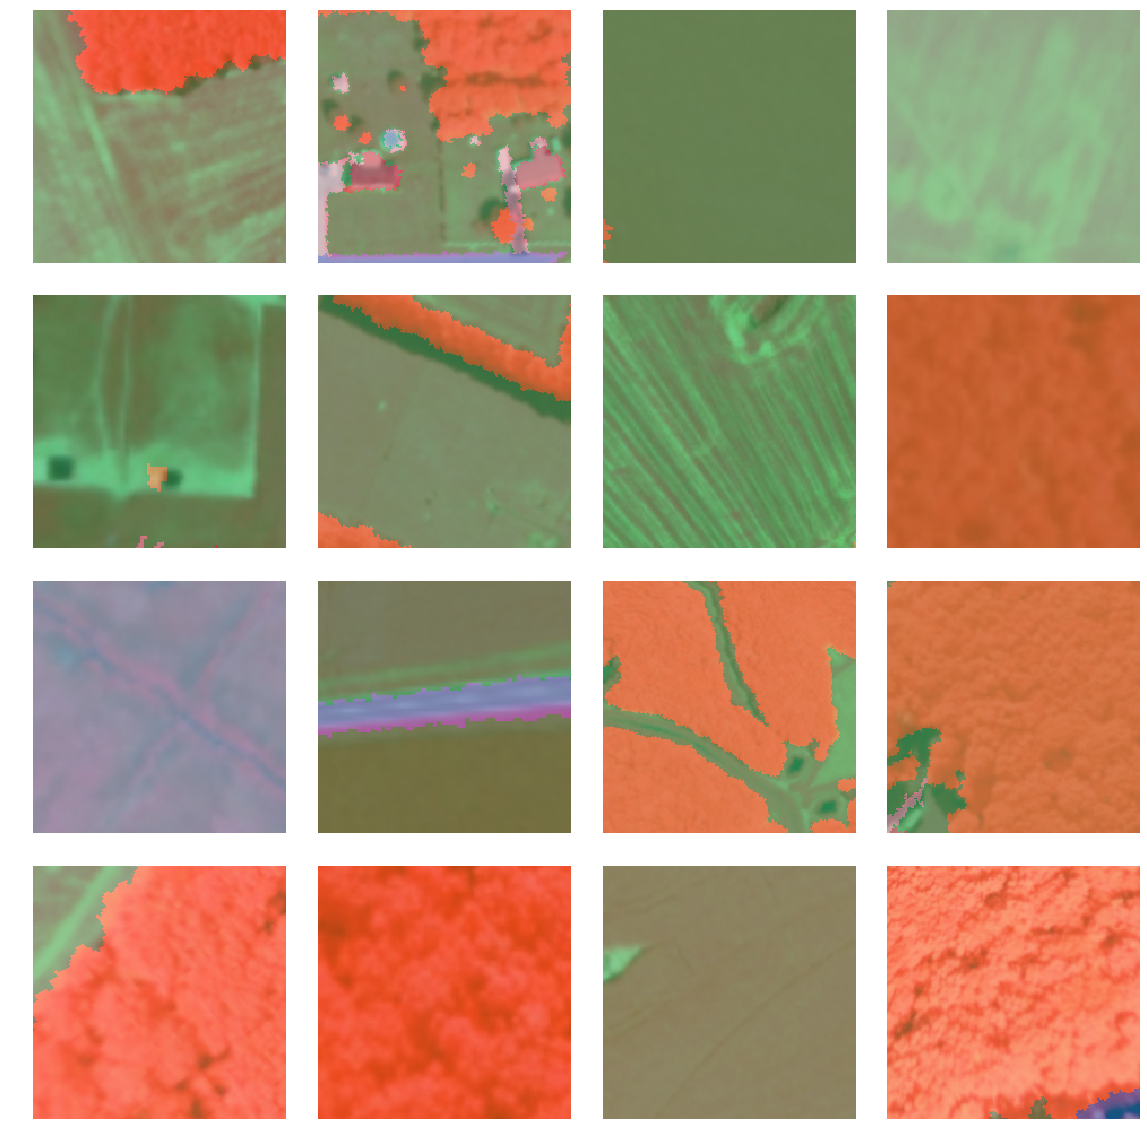

In [25]:
data.show_batch()

### Load model architecture
We will be using U-net, one of the well-recogonized image segmentation algorithm, for our land cover classification. U-Net is designed like an auto-encoder. It has an encoding path (“contracting”) paired with a decoding path (“expanding”) which gives it the “U” shape. However, in contrast to the autoencoder, U-Net predicts a pixelwise segmentation map of the input image rather than classifying the input image as a whole. For each pixel in the original image, it asks the question: “To which class does this pixel belong?”. U-Net passes the feature maps from each level of the contracting path over to the analogous level in the expanding path.  These are similar to residual connections in a ResNet type model, and allow the classifier to consider features at various scales and complexities to make its decision.

<center>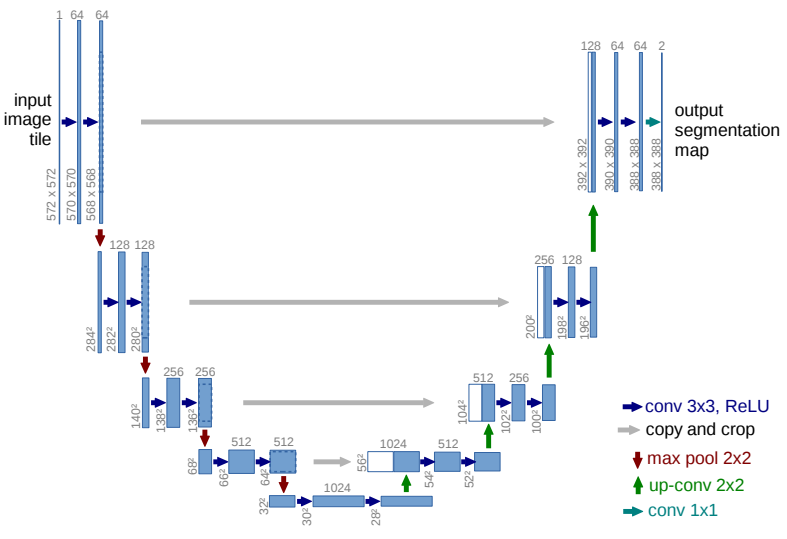 </center>
<center>Figure 2. Architecture of a Unet model</center>

In [26]:
model = UnetClassifier(data)

### Train a model through learning rate tuning and transfer learning
[Learning rate](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) is one of the most important hyperparameters in model training. Here we explore a range of learning rate to guide us to choose the best one.

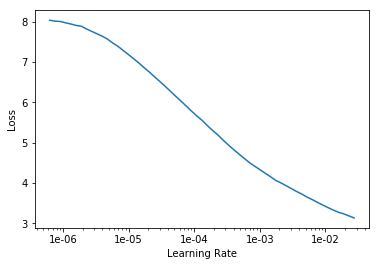

In [9]:
model.lr_find()

Based on the learning rate plot above, we can see that the loss going down dramatically at 1e-4. Therefore, we set learning rate to be a range from 3e-5 to 1e-4, which means we will apply smaller rates to the first few layers and larger rates for the last few layers, and intermediate rates for middle layers, which is the idea of transfer learning. Let's start with 10 epochs for the sake of time.

In [27]:
model.fit(10, lr=slice(3e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.488864,0.431946,0.873322
2,0.436592,0.362094,0.892988
3,0.358467,0.335168,0.899636
4,0.364898,0.321729,0.901571
5,0.351462,0.294477,0.906844
6,0.323483,0.288438,0.907954
7,0.317848,0.274222,0.912660
8,0.291879,0.286264,0.912971
9,0.284547,0.262629,0.915441
10,0.288180,0.260001,0.915736


### Visualize classification results in validation set
Now we have the model, let's look at how the model performs.

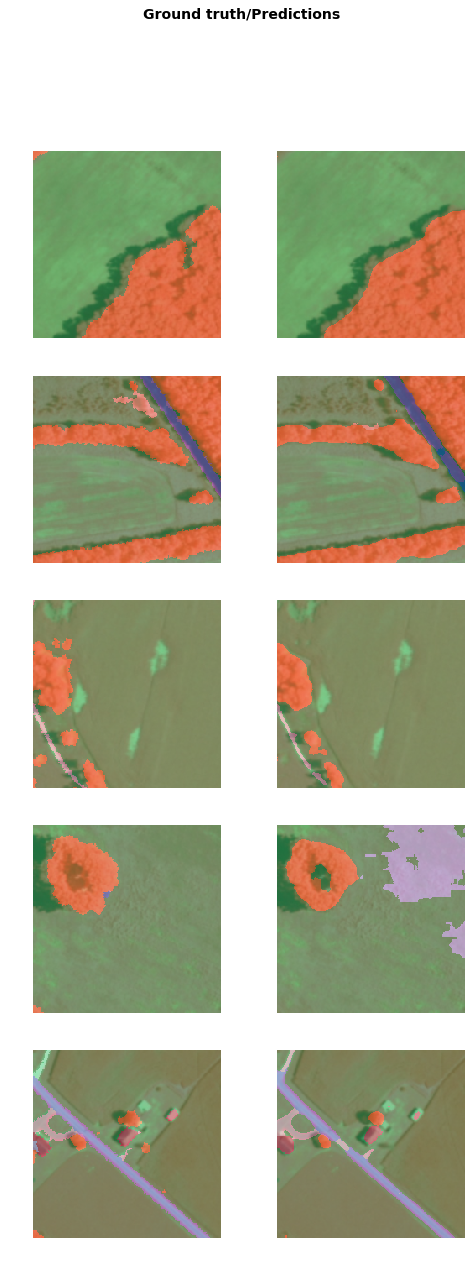

In [28]:
model.show_results()

As we can see, with only 10 epochs, we are already seeing reasonable results. Further improvment can be acheived through more sophisticated hyperparameter tuning. Let's save the model for further training or inference later. The model should be saved into a models folder in your folder. By default, it will be saved into your `data_path` that you specified in the very beginning of this notebook.

In [ ]:
model.save('stage-1-10')

## Deployment and inference

### Locate model package
If you have finished Part 2 of this notebook series, you should have a models folder saved already. The model package is the "stage-1-10.zip" zip file in the folder.
The the model package file includes several files:
1. A model definition file with the extension .emd which includes information like model framework (e.g. tensorflow, pytorch). ArcGIS will need it to interpret your model.
2. A model file in binary format that we have developed in Part 2.
3. If your framework is not supported yet, a custom python raster function has to be added as well.
Third, get the deep learning model package file path. _Please change it to your own path_.

In [3]:
model_package = "Path_To_Your_Model_Package"

In [4]:
classify_land_model_package = gis.content.add(item_properties={"type":"Deep Learning Package",
                                                                "typeKeywords":"Deep Learning, Raster",
                                                                "title":"Land_Cover_Kent_DL_Model",
                                                                "tags":"deeplearning", 'overwrite':'True'}, 
                                              data=model_package)

In [5]:
classify_land_model_package

<Item title:"Land_Cover_Kent_DL_Model" type:Deep Learning Package owner:portaladmin>

Now we are ready to install the mode. Installation of the deep learning model item will unpack the model definition file, model file and the inference function script, and copy them to "trusted" location under the Raster Analytic Image Server site's system directory. 

In [70]:
from arcgis.learn import Model, list_models

In [71]:
land_cover_model = Model(classify_land_model_package)

In [72]:
land_cover_model.install()

'[resources]models\\raster\\3908aa2cdcfa41389e73775165965378\\stage-1-10.emd'

### Model inference
To test our model, let's get a new raster image by specifying a spatial extent.

In [80]:
from arcgis.learn import classify_pixels

ext = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
 'xmin': -8411742.088727,
 'ymin': 4703820.069424,
 'xmax': -8395632.940157,
 'ymax': 4720903.740949}

context = {'cellSize': 2,
          'processorType':'GPU',
          'extent': ext,
          'batch_size': 9}

In [85]:
out_classify = classify_pixels(input_raster=naip_input_layer, # make sure pass in the layer not url
                               model=land_cover_model,
                               output_name="land_cover_sample_inference_result_06062019_4",
                               context=context,
                               gis=gis)

out_classify

<Item title:"land_cover_sample_inference_result_06062019_4" type:Imagery Layer owner:portaladmin>

## Visualize land cover classification on map

In [5]:
from arcgis.raster.functions import colormap

result_map = gis.map('Kent County, Delaware')
result_map.basemap ='satellite'

In [7]:
# applying color map [value, red, green, blue]
land_cover_colormap=[[0, 0, 0, 0],
                     [1, 0, 197, 255],
                     [2, 0, 168, 132],
                     [3, 38, 115, 0],
                     [4, 76, 230, 0],
                     [5, 163, 255, 115],
                     [6, 255, 170, 0],
                     [7, 255, 0, 0],
                     [8, 156, 156, 156],
                     [9, 0, 0, 0],
                     [10, 115, 115, 0],
                     [11, 230, 230, 0],
                     [12, 255, 255, 115],
                     [13, 0, 0, 0],
                     [14, 0, 0, 0],
                     [15, 0, 0, 0]]


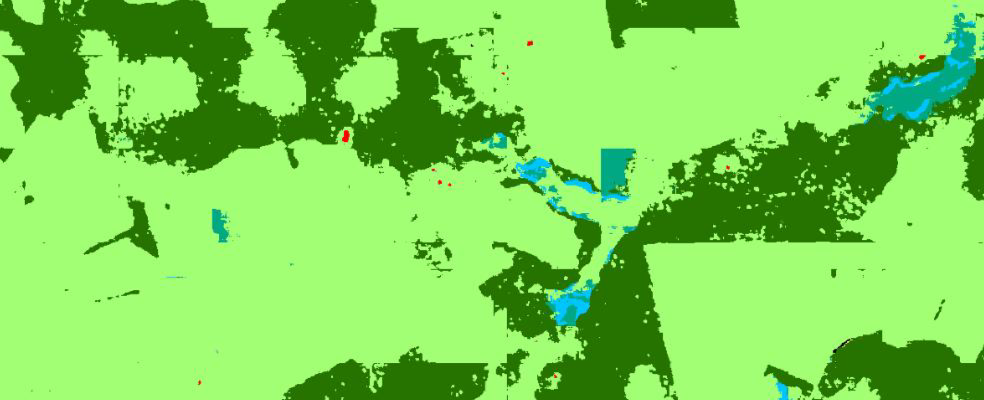

In [92]:
result_map.add_layer(colormap(out_classify.layers[0], 
                              colormap = land_cover_colormap, 
                              astype='u8'),
                    {'opacity':0.2})
result_map